### In this script we transform the action category to wordembedding and conduct weakly supervised learning

In [1]:
# Load arguments
import os
import re
import torch
import random
import string
import pickle
import matplotlib
import numpy as np
import pandas as pd
import utils.options
import torch.nn as nn
from nltk.stem import PorterStemmer
from tensorboardX import SummaryWriter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from utils.video_dataset import Dataset
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

import torch.nn.functional as F
from tensorboard_logger import log_value
import utils
import numpy as np
from torch.autograd import Variable
from utils.classificationMAP import getClassificationMAP as cmAP
from utils.detectionMAP import getDetectionMAP as dmAP
import scipy.io as sio
torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
%matplotlib inline  

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'


# Category to sentence
class_name = {0: ["baseball pitch", "throw a baseball", "baseball throw"],
             1: ["basketball dunk", "dunk a basketball", "slam dunk basketball"],
             2: ["billiards"],
             3: ["clean and jerk", "weight lifting movement"],
             4: ["cliff diving", "high diving", "diving"],
             5: ["cricket shot" ],
             6: ["cricket bowling", "cricket movement", "bowl cricket"],
             7: ["diving", "jumping into water", "falling into water"],
             8: ["frisbee catch", "catch frisbee"],
             9: ["golf swing", "golf stroke"],
            10: ["hammer throw", "throw a hammer"],
            11: ["high jump"],
            12: ["javelin throw", "throw a spear"],
            13: ["long jump", "jump contest"],
            14: ["pole vault", "a person uses a long flexible pole to jump over a bar"],
            15: ["shot put"],
            16: ["soccer penalty"],
            17: ["tennis swing"],
            18: ["throw discus", "discus"],
            19: ["volleyball spiking", "volleyball", ]}

args = Args()

# Load the dataset
dataset = Dataset(args)

# Word Embedding Loading from GLOVE
path_to_glove = './checkpoint/glove.840B.300d.pkl'

with open(path_to_glove, "rb") as input_file:
    glove_model = pickle.load(input_file)

In [5]:
# Build up the language model and LSTM

class Visual_model(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim=2048):
        super(Visual_model, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(2048, 20)
        self.fc_lr = nn.Linear(2048, 100)

    def forward(self, features_list, t_proposals=None, test=False):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)
        t_proposals:    temporal proposals generated from T-CAM, for boostrapping LSTM training.

        Returns:
        The attention weights, weigted features
        """
        
        attention_weights = []
        weighted_features = []
        pos_features = []
        neg_features = []
        # Test_features are returning tensors (batch, length, feat_dim)
        test_features = []
        
        # Iterate through batch since length of each video segment varies
        for idx, video_features in enumerate(features_list):
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]

            # Iterate through video segments
            output = self.sigmoid(self.fc2(self.relu(self.fc1(self.relu(self.fc0(video_features))))))

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # If testing, feed weighted video_features (no mean pool) to fc_lr
            if test:
                test_features.append(self.fc_lr((output*video_features)))
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)

            # Pool pos/neg segments features from T-CAM proposals
            if t_proposals is not None:
                pos_list = [index for index, l in enumerate(t_proposals[idx]) if l == 1.]
                neg_list = [index for index, l in enumerate(t_proposals[idx]) if l == 0.]
                
                pos_feature = torch.stack([feat for index, feat in enumerate(video_features) if index in pos_list]).sum(0)/len(pos_list)
                neg_feature = torch.stack([feat for index, feat in enumerate(video_features) if index in neg_list]).sum(0)/len(neg_list)
                
                pos_features.append(pos_feature)
                neg_features.append(neg_feature)
                
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)
        
        # Feed temporal features to fc regression layer
        # output: aggregated visual representations
        output = self.fc_lr(weighted_features)
        
        if test:
            return attention_weights, output, None, None, test_features
        else:
            # training without t-cam bootstrapping
            if t_proposals is None:
                return attention_weights, output, None, None, None
            # training with t-cam bootstrapping
            else:
                pos_features = torch.stack(pos_features)
                neg_features = torch.stack(neg_features)
                pos_features = self.fc_lr(pos_features)
                neg_features = self.fc_lr(neg_features)
                return attention_weights, output, pos_features, neg_features, None



class Language_encoder(nn.Module):
    """Args:
        Natural Language Text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Language_encoder, self).__init__()
        """
            Load GLOVE pre-trained model first.
        """
        with open(path_to_glove, "rb") as input_file:
            self.glove = pickle.load(input_file)
        self.wordnet_lemmatizer = WordNetLemmatizer() 

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.time_steps = time_steps
        
        # Define the LSTM/fc module
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def language_preprocess(self, input_str):
        # convert to lowercase
        input_str = input_str.lower()
        # remove numbers
        input_str = re.sub(r'\d+', '', input_str)
        # remove punctuation
        input_str = re.sub(r'[^\w\s]','',input_str)
        # remove whitespaces
        input_str = input_str.strip()
        # remove stop words
        stop_words = set(ENGLISH_STOP_WORDS)
        tokens = word_tokenize(input_str)
        words = [i for i in tokens if not i in stop_words]
        # stemming the words
        words = [self.wordnet_lemmatizer.lemmatize(word) for word in words]
        return words
    
    def zero_pad_feature(self, word_dict):
        # transform to tensor input, and zero padding the extra feature
        input_seq = torch.zeros(self.time_steps, len(word_dict), lstm_input_size).cuda()
        
        for i in range(len(word_dict)):
            for j in range(self.time_steps):
                if j < len(word_dict[i]):
                    # word2vec extracting
                    input_seq[j, i, :] = torch.from_numpy(glove_model[word_dict[i][j]]).cuda()
        return input_seq
    
    def forward(self, text):
        """
            Text will be pre-processed first, and zero-padded for LSTM input.
        """
        word_dict = []
        for lines in text:
            word_dict.append(self.language_preprocess(lines))
        input_seq = self.zero_pad_feature(word_dict)
        
        lstm_out, _ = self.lstm(input_seq)
        last_output = lstm_out[-1]
        output = self.linear(last_output)
        
        return output

    
    
class Model(nn.Module):
    """Args:
        Video I3D features and raw natural text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Model, self).__init__()
        """
            Create Duo Strean Model.
        """
        self.textual_model = Language_encoder(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers, path_to_glove
                                              =path_to_glove)
        self.visual_model = Visual_model()
    
    def forward(self, visual_feature, text, t_proposals=None, test=False):
        """
            pos/neg_feature: (batch, 2048).       
                mean_pooled representations.
        """
        attention_weights, visual_feature, pos_feature, neg_feature, test_features = \
            self.visual_model(visual_feature, t_proposals=t_proposals, test=test)
        textual_feature = self.textual_model(text_list)

        return attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features
            
    

    
# Stacking all laebls to language format
def label_to_text(labels):
    text_list = []
    for label in labels:
        idxs = [idx for idx, val in enumerate(label) if val==1]
        text = ''
        for idx in idxs:
            text += ' ' + random.choice(class_name[idx])
        text_list.append(text)
    return text_list


# L1 normalization for weights regularization
def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


# Sample single label from multi ground truth
def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()


# T-cam with specific label
def temporal_proposals(weights, features, clses):
    """
        Return the binary temporal proposals based on T-CAM.
        Input: 
            features:    (batch, # of segments, # of dim)
            cls:         (batch, class_label)
        Return:    [batch, # of untrimmed segments(binary)]
    """
    proposals = []
    # Iterate through batch
    for idx, video_feature in enumerate(features):
        # Chunk video feature to real length
            seq_len = (torch.abs(video_feature).max(dim=1)[0] > 0).sum().tolist()
            video_feature = video_feature[: seq_len, :]
            scores = np.zeros(seq_len)
            for seg_id, feature in enumerate(video_feature):
                for cls in clses[idx]:
                    score = (feature*weights[cls]).sum()
                    scores[seg_id] += score
            # Labeling segments with scores larger than threshold
            threshold = (np.max(scores) - (np.max(scores) - np.min(scores))*0.5)
            proposals.append([1 if s > threshold else 0 for idx, s in enumerate(scores)])
    return proposals


def temp2(attention_weights, labels):
    weights = torch.zeros(len(attention_weights), 20)
    idx_list = [i for i, val in enumerate(labels) if val == 1.0]
    for idx, val in enumerate(idx_list):
        weights[:, val] = attention_weights
    return weights

In [6]:
# Duo Model testing
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

textual_model = Language_encoder(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)
visual_model = Visual_model()
textual_model.cuda()
visual_model.cuda()
print('model loaded')

# Load feature and converting to CUDA
features, labels = dataset.load_data(is_training=True)
features = torch.from_numpy(features).float().to('cuda')

# Generate texts from categories
text_list = label_to_text(labels)

attention_weights, visual_feature = visual_model(features)
textual_feature = textual_model(text_list)

# Testing Squared Loss
loss = torch.mean((visual_feature-textual_feature)**2)

model loaded


ValueError: too many values to unpack (expected 2)

## Train Weakly Supervised Duo Stream Model 

In [15]:
# Duo Model testing
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)

# Load pre-trained classification network for bootstrapping
checkpoint = torch.load('./checkpoint/temporal_cls_epoch_15000_bceloss.pth')
pretrained_dict = checkpoint['state_dict']

# filter out unnecessary keys and load valid params
model_dict = model.visual_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
model.visual_model.load_state_dict(model_dict)


model.cuda()
model.textual_model.cuda()
model.visual_model.cuda()
print('model created')

# Store the fc weights for t-cam prediction
args.weights = model.visual_model.fc3.weight.detach().cpu()

# Loss defined here
marginrankingloss = nn.MarginRankingLoss(0.1)

def euclidean_distance(v1, v2, dim=None):
    if dim is not None: 
        return torch.mean((v1-v2)**2, dim)
    else:
        return torch.mean((v1-v2)**2)

# Optimizer
lr = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

writer = SummaryWriter()

model created


Epoch:000, Loss: 0.014020158909261227


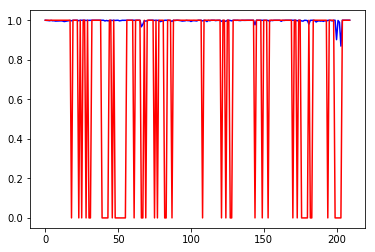

Epoch:100, Loss: 0.010618497617542744


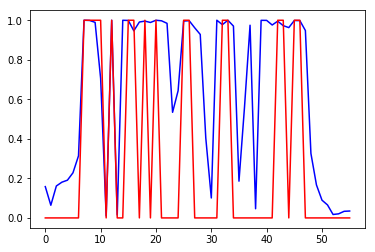

Epoch:200, Loss: 0.01014058105647564


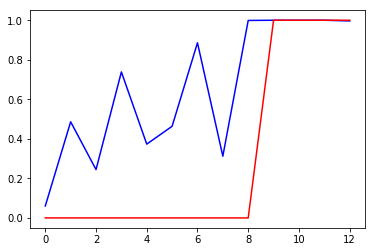

Epoch:300, Loss: 0.007012483663856983


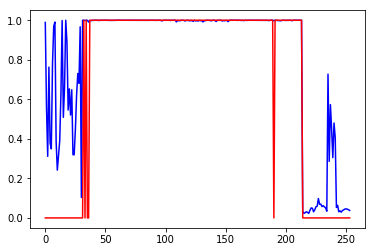

Epoch:400, Loss: 0.006141302175819874


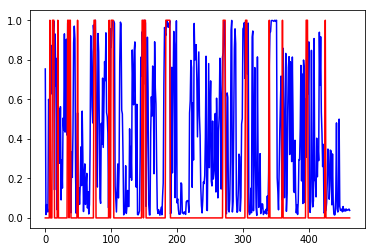

Epoch:500, Loss: 0.00576746417209506


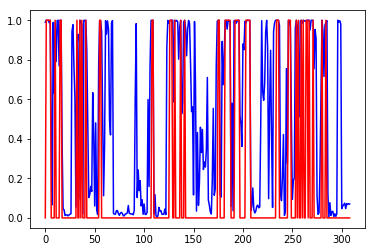

Epoch:600, Loss: 0.005546198226511478


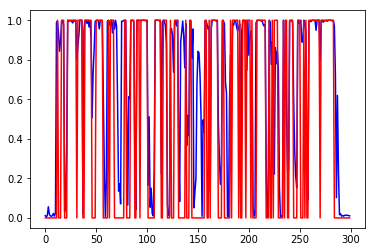

Epoch:700, Loss: 0.006427805405110121


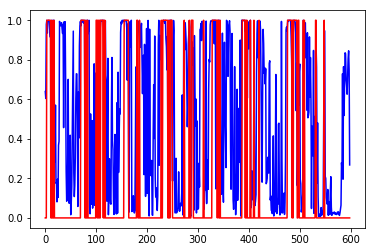

Epoch:800, Loss: 0.00423505948856473


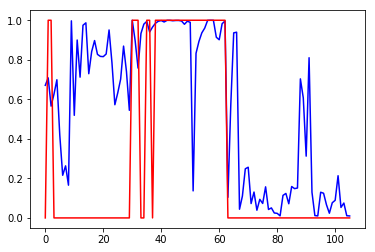

Epoch:900, Loss: 0.004187590908259153


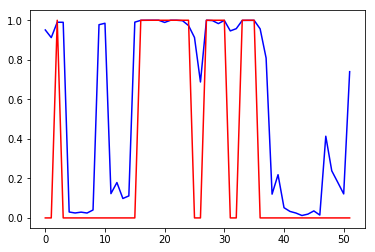

Epoch:1000, Loss: 0.00436355359852314


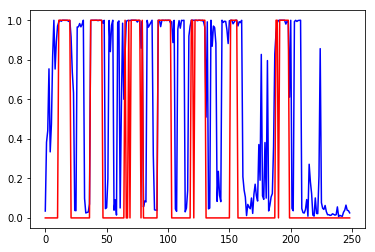

Epoch:1100, Loss: 0.003923882730305195


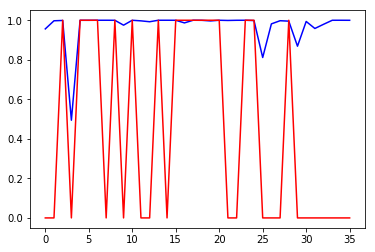

Epoch:1200, Loss: 0.0040789456106722355


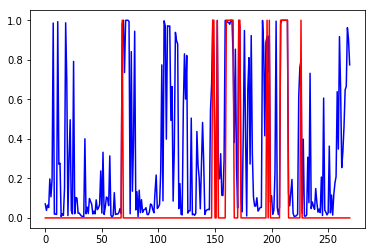

Epoch:1300, Loss: 0.0033875242806971073


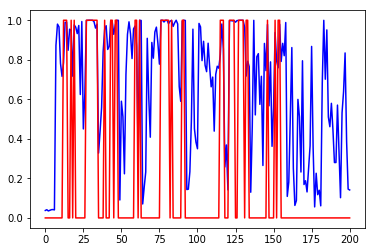

Epoch:1400, Loss: 0.0035844421945512295


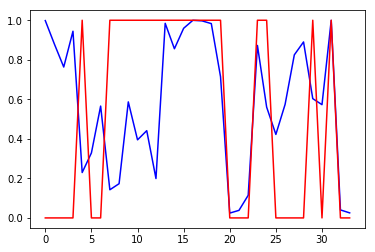

Epoch:1500, Loss: 0.0039789569564163685


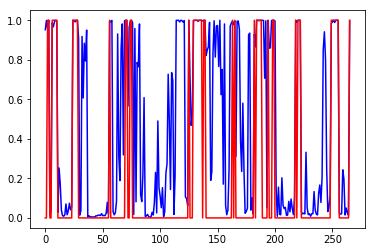

Epoch:1600, Loss: 0.0036585149355232716


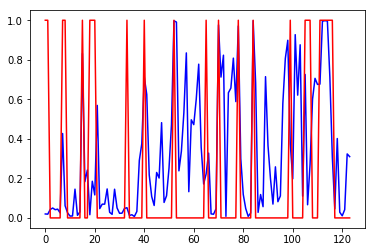

Epoch:1700, Loss: 0.0027230256237089634


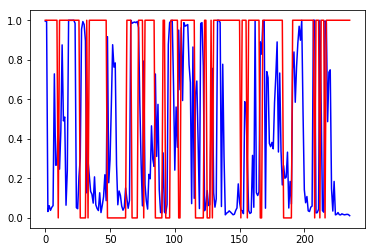

Epoch:1800, Loss: 0.003017934039235115


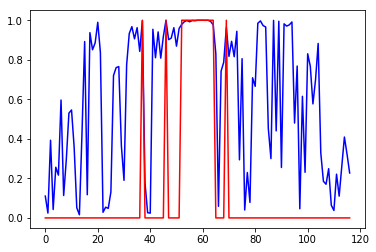

Epoch:1900, Loss: 0.003517981618642807


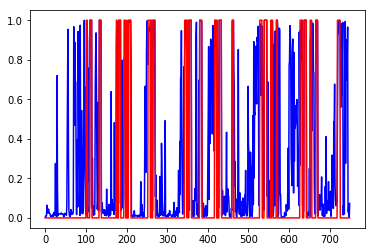

Epoch:2000, Loss: 0.0031089780386537313


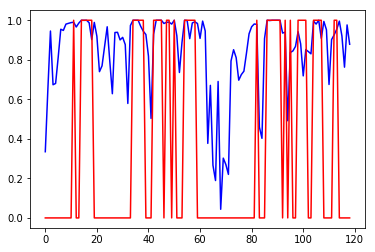

Epoch:2100, Loss: 0.003346063196659088


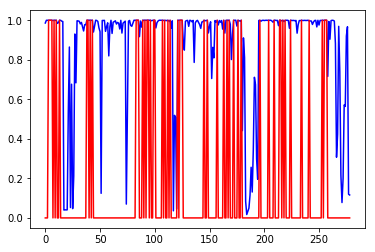

Epoch:2200, Loss: 0.0036146012134850025


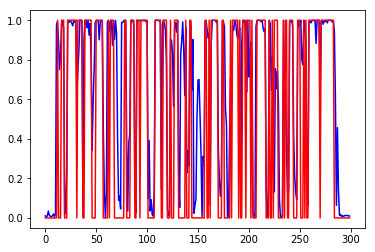

Epoch:2300, Loss: 0.003505849512293935


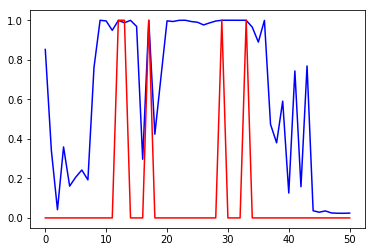

Epoch:2400, Loss: 0.003001235658302903


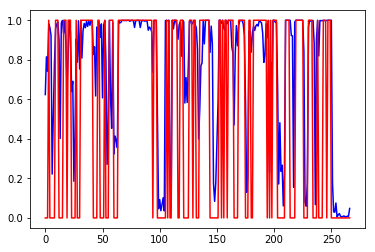

Epoch:2500, Loss: 0.0036432133056223392


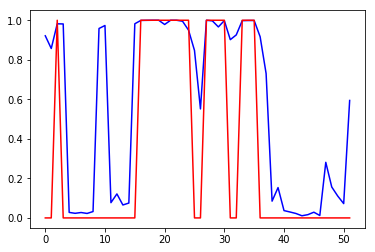

Epoch:2600, Loss: 0.003175043500959873


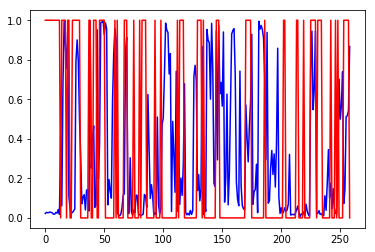

Epoch:2700, Loss: 0.003419596701860428


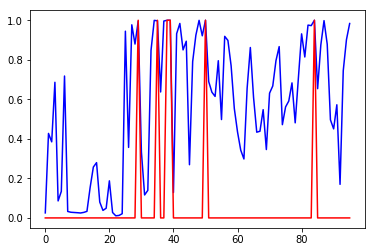

Epoch:2800, Loss: 0.0028328076004981995


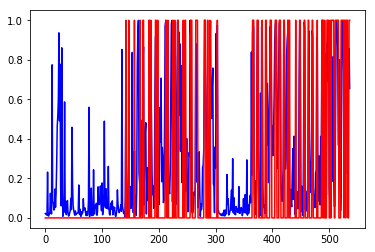

Epoch:2900, Loss: 0.004111771937459707


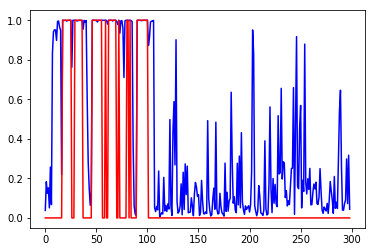

Epoch:3000, Loss: 0.0029304574709385633


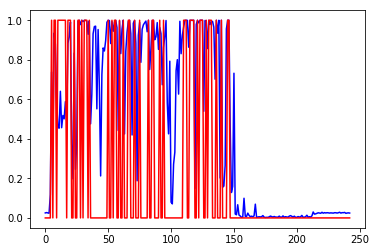

Epoch:3100, Loss: 0.003123302012681961


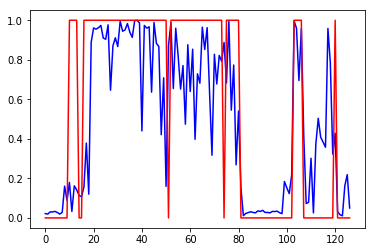

Epoch:3200, Loss: 0.004040152300149202


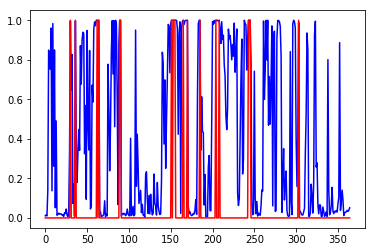

Epoch:3300, Loss: 0.0045187161304056644


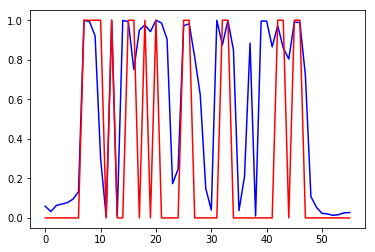

Epoch:3400, Loss: 0.003474158002063632


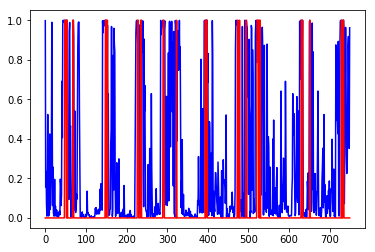

Epoch:3500, Loss: 0.002653648378327489


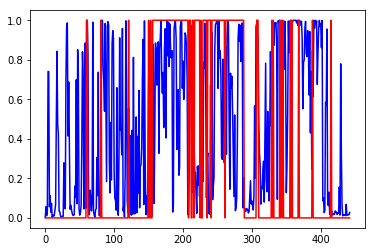

Epoch:3600, Loss: 0.004306243732571602


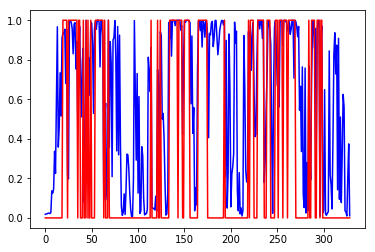

Epoch:3700, Loss: 0.003393326885998249


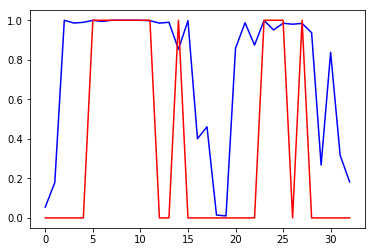

Epoch:3800, Loss: 0.0025795772671699524


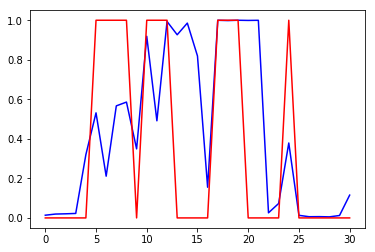

Epoch:3900, Loss: 0.0033824520651251078


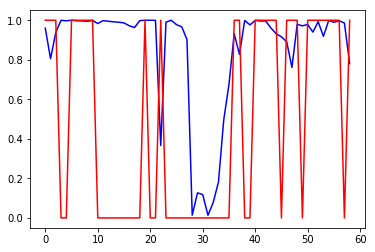

Epoch:4000, Loss: 0.00260029174387455


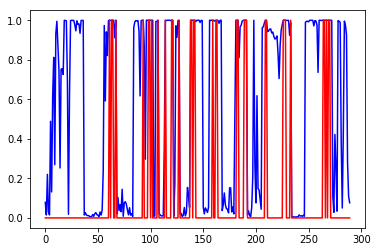

Epoch:4100, Loss: 0.003253117436543107


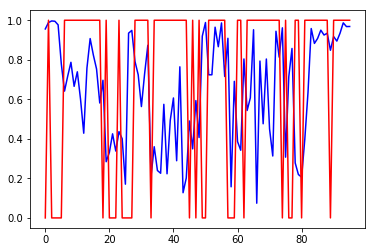

Epoch:4200, Loss: 0.0033754552714526653


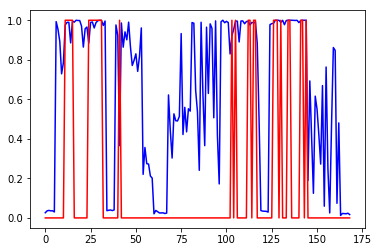

Epoch:4300, Loss: 0.0029406100511550903


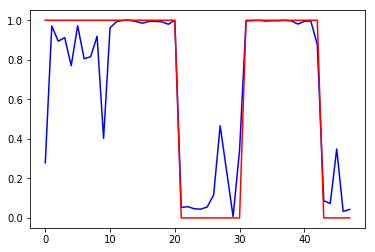

Epoch:4400, Loss: 0.002882939064875245


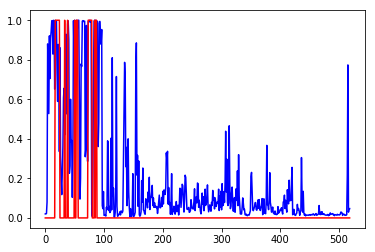

Epoch:4500, Loss: 0.003865176346153021


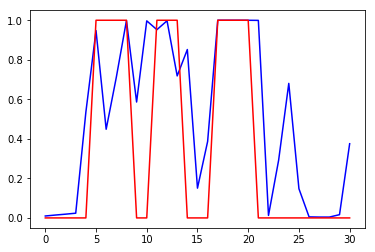

Epoch:4600, Loss: 0.0027172542177140713


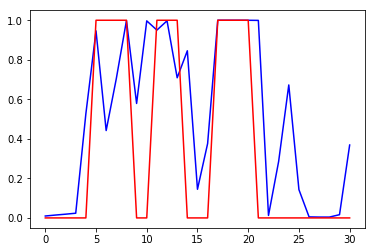

Epoch:4700, Loss: 0.002720302902162075


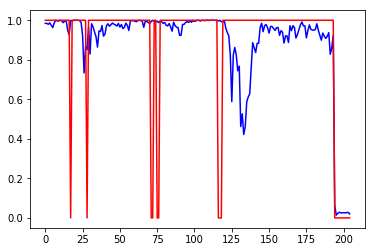

Epoch:4800, Loss: 0.002799075562506914


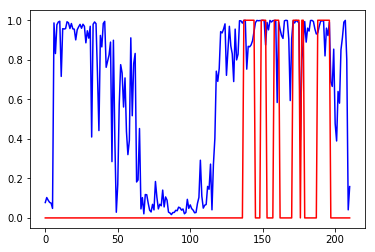

Epoch:4900, Loss: 0.0032665261533111334


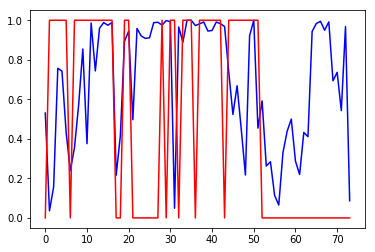

Epoch:5000, Loss: 0.003086748532950878


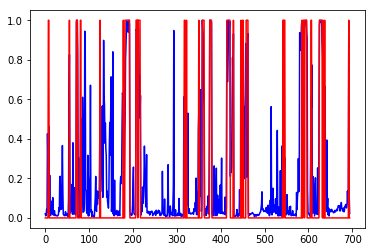

Epoch:5100, Loss: 0.003378724679350853


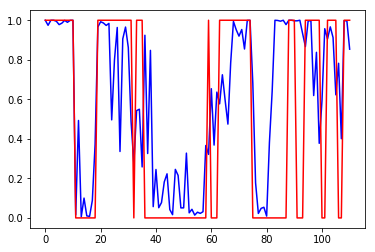

Epoch:5200, Loss: 0.003657137043774128


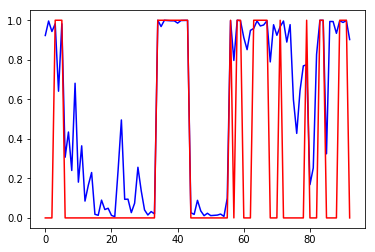

Epoch:5300, Loss: 0.0024716886691749096


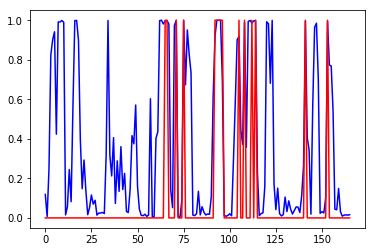

Epoch:5400, Loss: 0.002520497888326645


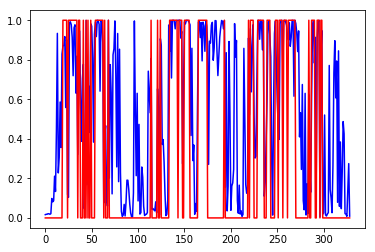

Epoch:5500, Loss: 0.003389535006135702


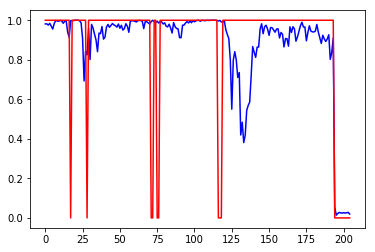

Epoch:5600, Loss: 0.00318803358823061


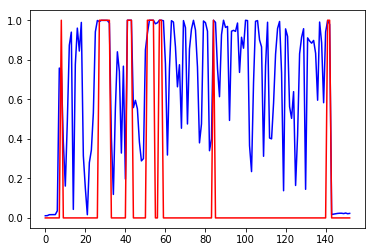

Epoch:5700, Loss: 0.002781357616186142


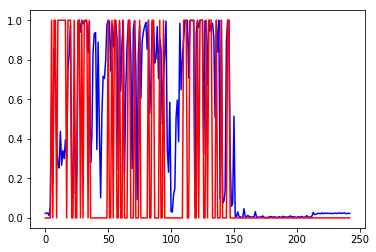

Epoch:5800, Loss: 0.0033373443875461817


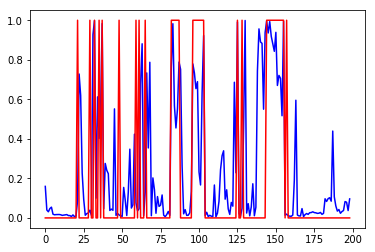

Epoch:5900, Loss: 0.002788141369819641


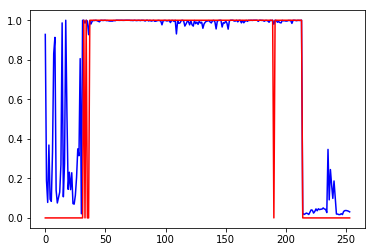

Epoch:6000, Loss: 0.0031694862991571426


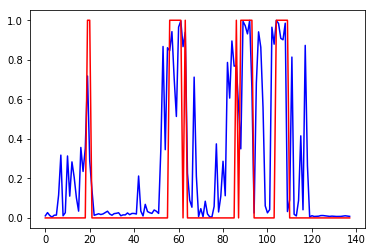

Epoch:6100, Loss: 0.0023624864406883717


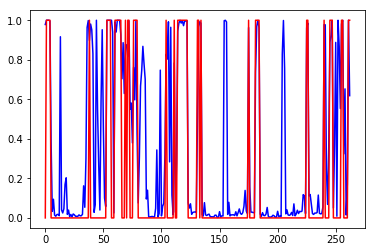

Epoch:6200, Loss: 0.003615208435803652


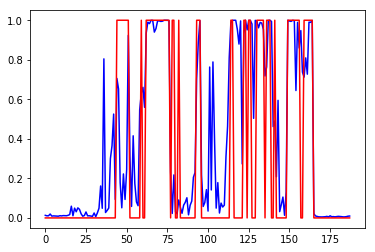

Epoch:6300, Loss: 0.0027547236531972885


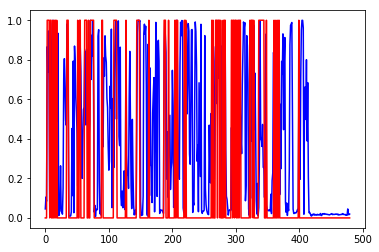

Epoch:6400, Loss: 0.0025585810653865337


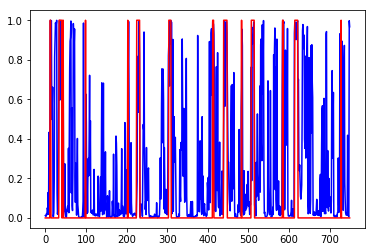

Epoch:6500, Loss: 0.002638924401253462


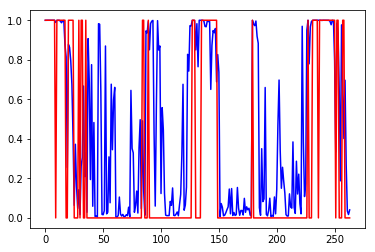

Epoch:6600, Loss: 0.003443103516474366


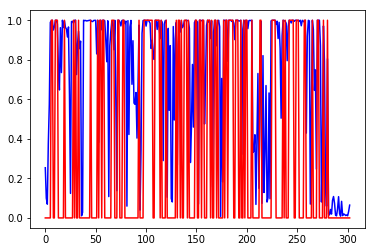

Epoch:6700, Loss: 0.003420993685722351


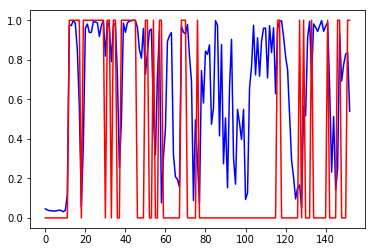

Epoch:6800, Loss: 0.002596587408334017


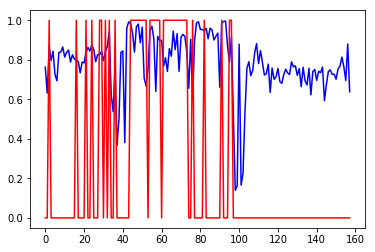

Epoch:6900, Loss: 0.0021506929770112038


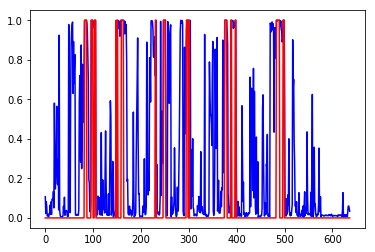

Epoch:7000, Loss: 0.002619212493300438


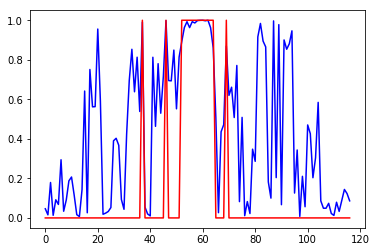

Epoch:7100, Loss: 0.002886336762458086


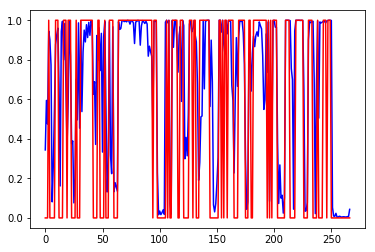

Epoch:7200, Loss: 0.002460430609062314


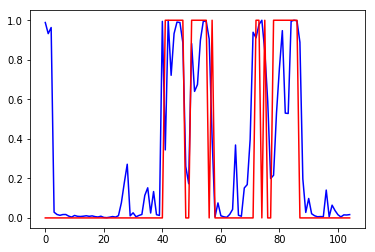

Epoch:7300, Loss: 0.003452728968113661


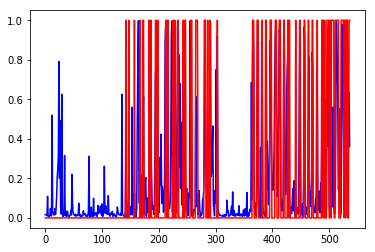

Epoch:7400, Loss: 0.002565501956269145


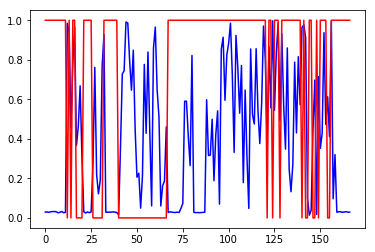

Epoch:7500, Loss: 0.003106197342276573


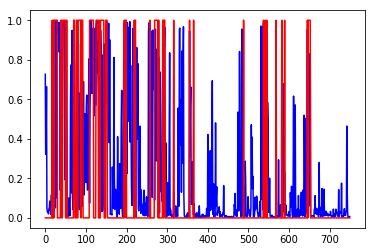

Epoch:7600, Loss: 0.0025880211032927036


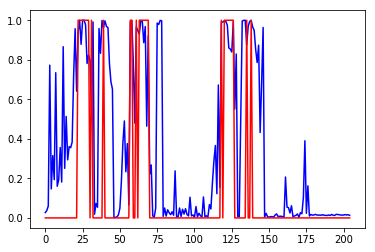

Epoch:7700, Loss: 0.0024856391828507185


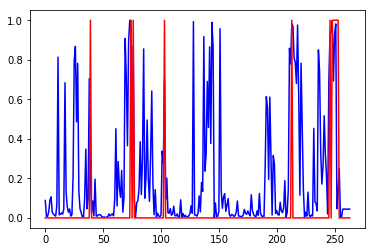

Epoch:7800, Loss: 0.0025843647308647633


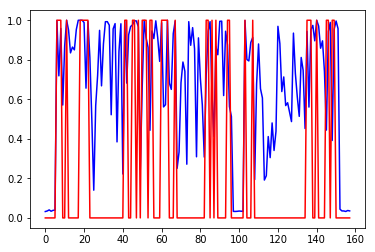

Epoch:7900, Loss: 0.003336723893880844


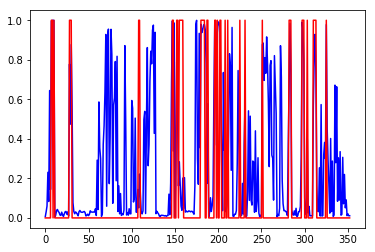

Epoch:8000, Loss: 0.002619776874780655


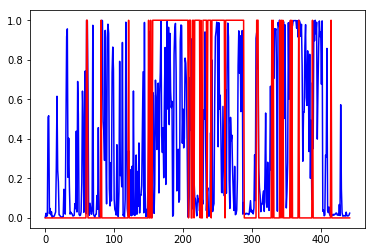

Epoch:8100, Loss: 0.0028372183442115784


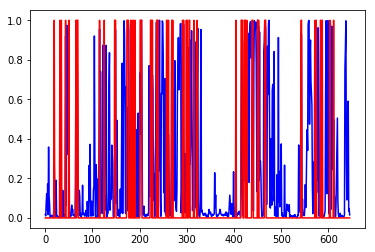

Epoch:8200, Loss: 0.002192289801314473


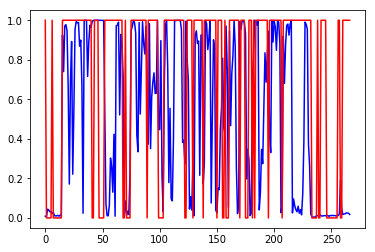

Epoch:8300, Loss: 0.0027152884285897017


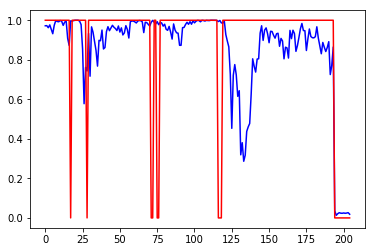

Epoch:8400, Loss: 0.003263167105615139


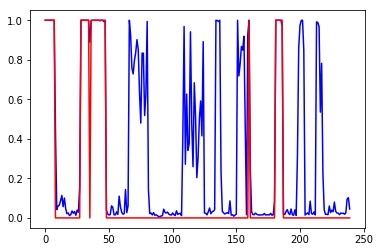

Epoch:8500, Loss: 0.002857046201825142


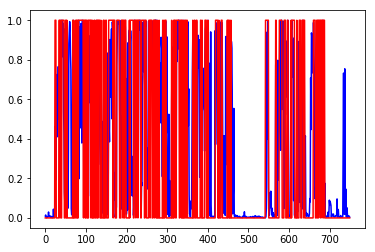

Epoch:8600, Loss: 0.0035551767796278


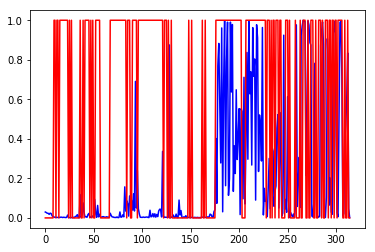

Epoch:8700, Loss: 0.0036339801736176014


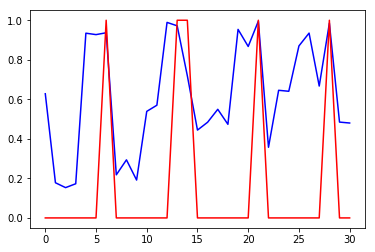

Epoch:8800, Loss: 0.0032807677052915096


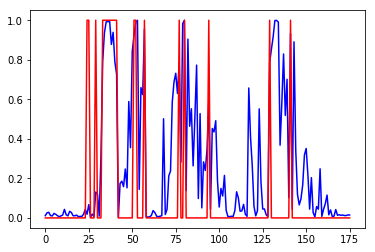

Epoch:8900, Loss: 0.0026702051982283592


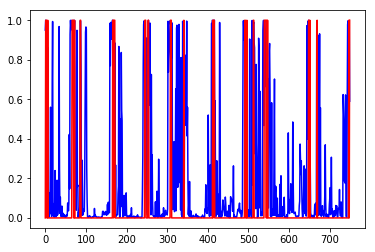

Epoch:9000, Loss: 0.0028544762171804905


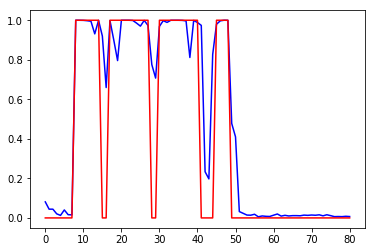

Epoch:9100, Loss: 0.00297235744073987


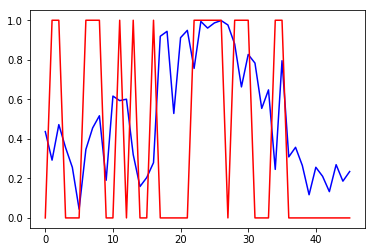

Epoch:9200, Loss: 0.0025966695975512266


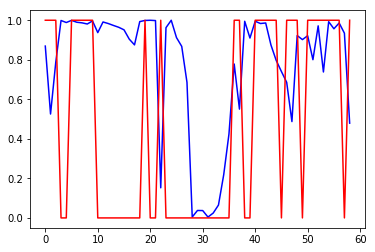

Epoch:9300, Loss: 0.003439699299633503


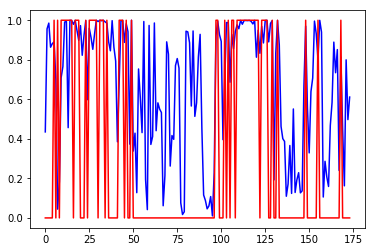

Epoch:9400, Loss: 0.0020850859582424164


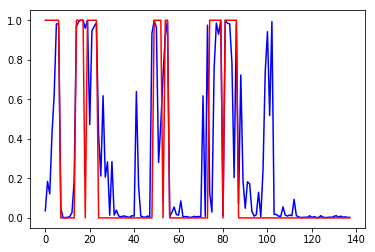

Epoch:9500, Loss: 0.002831661608070135


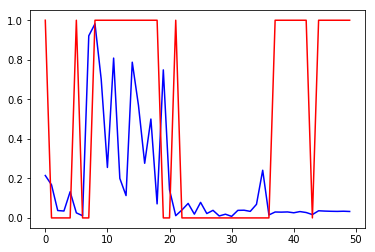

Epoch:9600, Loss: 0.0029077515937387943


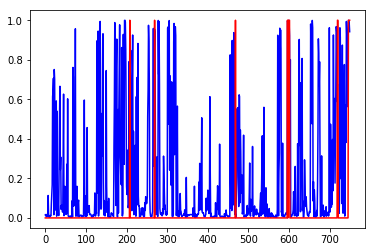

Epoch:9700, Loss: 0.0026410287246108055


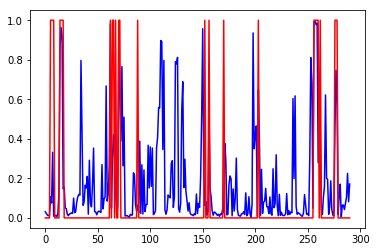

Epoch:9800, Loss: 0.0026824302040040493


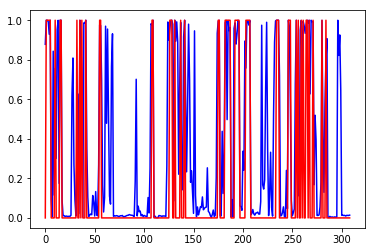

Epoch:9900, Loss: 0.002896255347877741


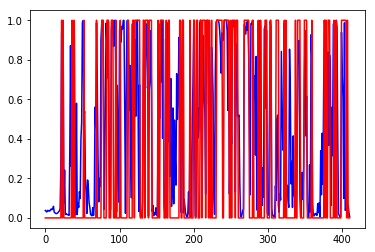

Epoch:10000, Loss: 0.0023098273668438196


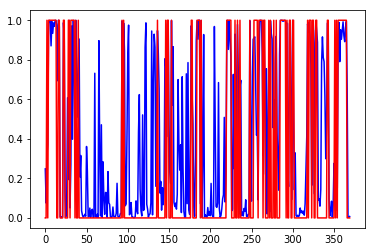

Epoch:10100, Loss: 0.0030054571107029915


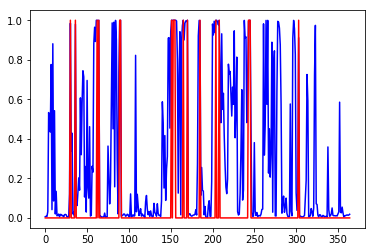

Epoch:10200, Loss: 0.002359816338866949


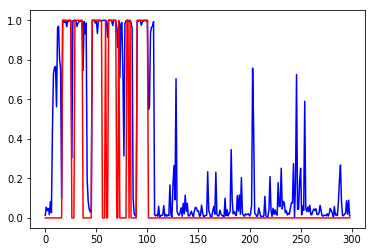

Epoch:10300, Loss: 0.0030173822306096554


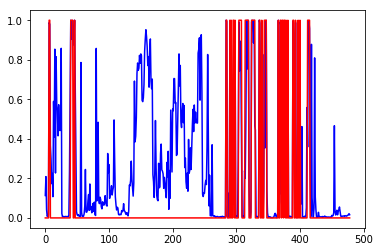

Epoch:10400, Loss: 0.0027818898670375347


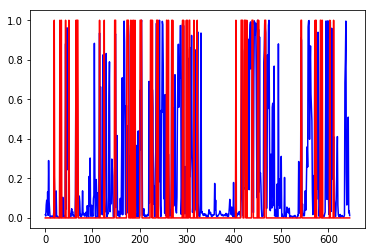

Epoch:10500, Loss: 0.002654049778357148


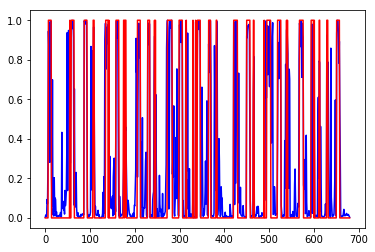

Epoch:10600, Loss: 0.0022974801249802113


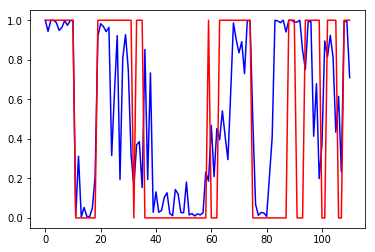

Epoch:10700, Loss: 0.0024776787031441927


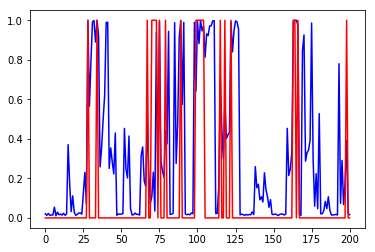

Epoch:10800, Loss: 0.002598906634375453


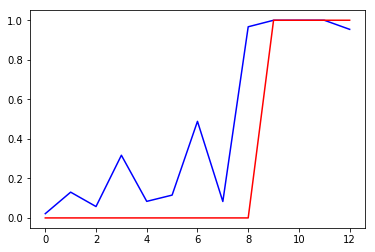

Epoch:10900, Loss: 0.0029461681842803955


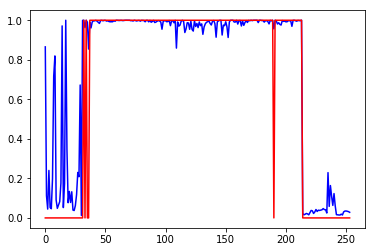

Epoch:11000, Loss: 0.0028530186973512173


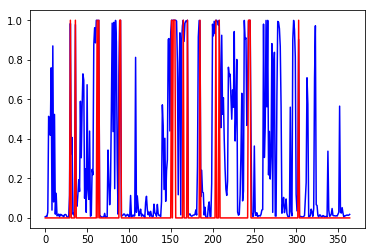

Epoch:11100, Loss: 0.0028457101434469223


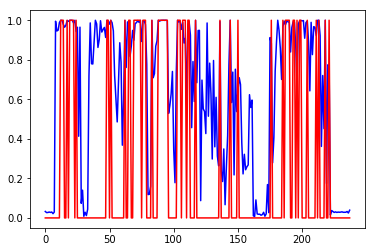

Epoch:11200, Loss: 0.0023932233452796936


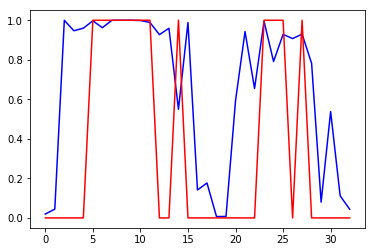

Epoch:11300, Loss: 0.0025098000187426805


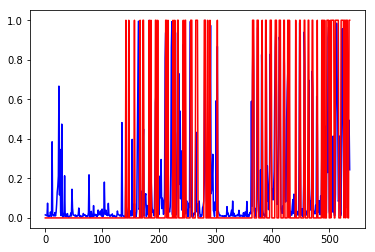

Epoch:11400, Loss: 0.002576797269284725


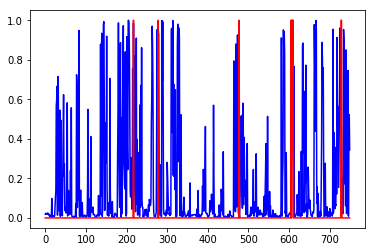

Epoch:11500, Loss: 0.0022856297437101603


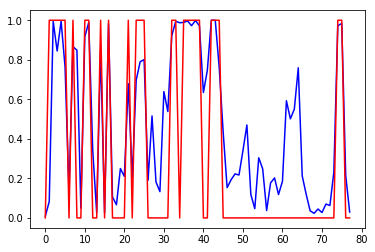

Epoch:11600, Loss: 0.002166690770536661


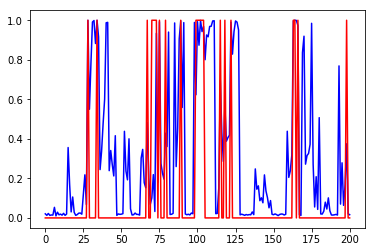

Epoch:11700, Loss: 0.0022251037880778313


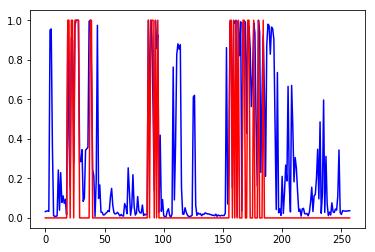

Epoch:11800, Loss: 0.002320042811334133


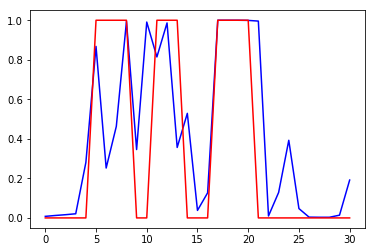

Epoch:11900, Loss: 0.002979758195579052


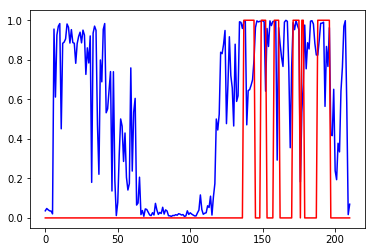

Epoch:12000, Loss: 0.0031621218658983707


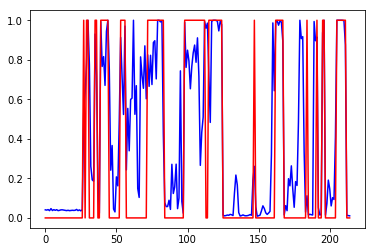

Epoch:12100, Loss: 0.002433642279356718


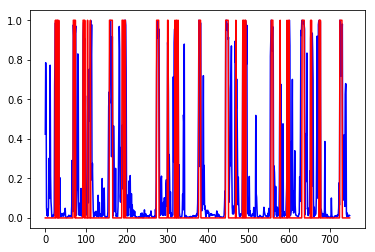

Epoch:12200, Loss: 0.0037875412963330746


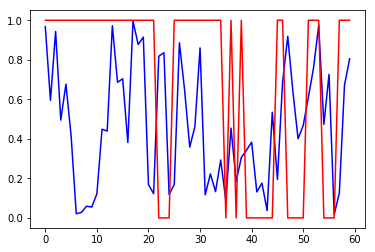

Epoch:12300, Loss: 0.00244584446772933


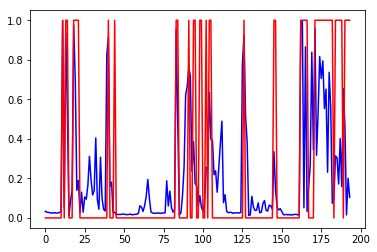

Epoch:12400, Loss: 0.0026006419211626053


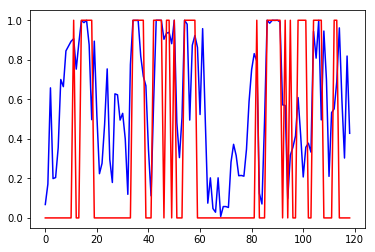

Epoch:12500, Loss: 0.002170140855014324


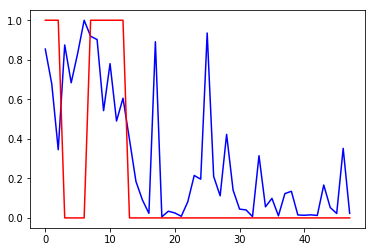

Epoch:12600, Loss: 0.00296240346506238


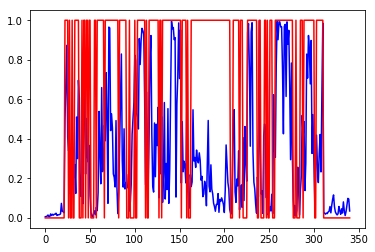

Epoch:12700, Loss: 0.001938440604135394


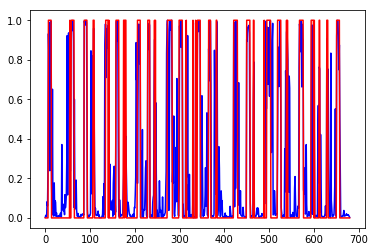

Epoch:12800, Loss: 0.002809324534609914


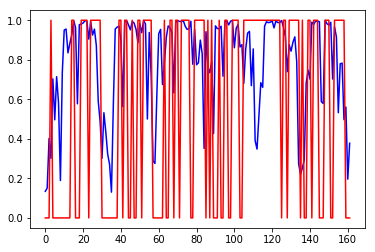

Epoch:12900, Loss: 0.0022203680127859116


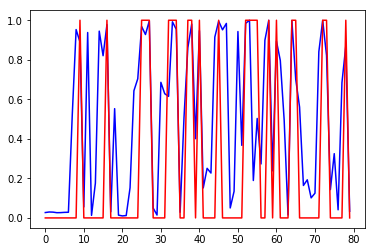

Epoch:13000, Loss: 0.002377674449235201


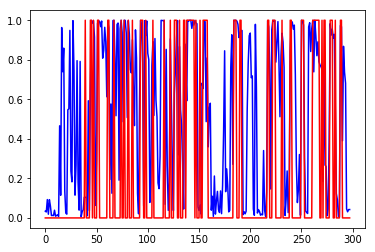

Epoch:13100, Loss: 0.0022711113560944796


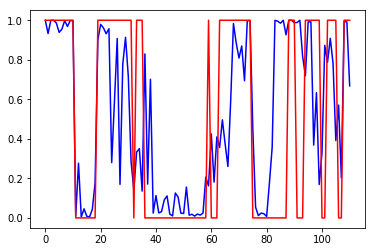

Epoch:13200, Loss: 0.0025264592841267586


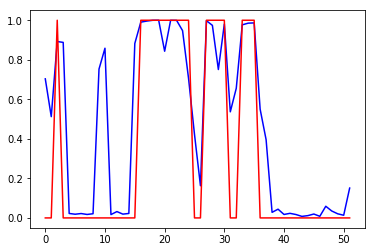

Epoch:13300, Loss: 0.002968062646687031


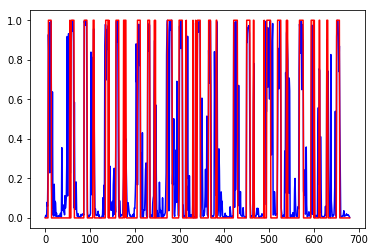

Epoch:13400, Loss: 0.0022491198033094406


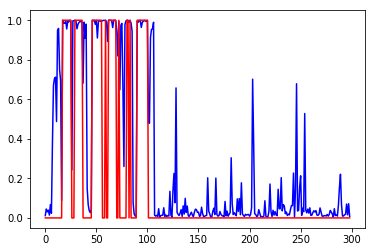

Epoch:13500, Loss: 0.002973472233861685


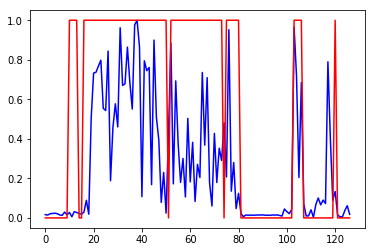

KeyboardInterrupt: 

In [16]:
for epoch in range(args.max_iter):
    # Randomly extract 10 video clips' I3D feature
    features, labels = dataset.load_data(n_similar=args.num_similar)

    # Features are alingned in 750 frames all the same, now trunk it into max length
    seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
    features = features[:,:np.max(seq_len),:]

    # Convert to CUDA tensor
    features = torch.from_numpy(features).float().to('cuda')
    labels = torch.from_numpy(labels).float().to('cuda')

    # Generate texts from categories
    text_list = label_to_text(labels)

    # Generate Pos/Neg temporal segment mask for contrastive loss
    clses = [[idx for idx, cls in enumerate(label) if cls == 1.] for label in labels]
    t_proposals = temporal_proposals(args.weights, features.detach().cpu(), clses)

    attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features\
        = model(features, text_list, t_proposals)

    # Squared Loss, Margin Ranking Loss
    pos_distance = euclidean_distance(pos_feature, textual_feature, 1)
    neg_distance = euclidean_distance(neg_feature, textual_feature, 1)
    target = torch.zeros(visual_feature.shape[0]).cuda()-1

    margin_loss = marginrankingloss(pos_distance, neg_distance, target)

    loss = euclidean_distance(visual_feature, textual_feature) + 0.01*margin_loss 
#     + 0.00001*l1_norm(attention_weights)


    # Back Propogation
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()

    # Save checkpoint
    if epoch % 5000 == 0 and epoch is not 0:
        # Reduce lr 
        lr /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Checkpoint structure
        model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }

        torch.save(model_state, os.path.join(args.checkpoint_path, 'model_nlp_epoch_{:03}.pth'.format(epoch)))
    

    # Print out training loss
    loss_value = loss.detach().cpu().tolist()
    writer.add_scalar('runs/', loss_value, epoch)


    if epoch % 100 == 0:
        print('Epoch:{:03}, Loss: {:02}'.format(epoch, loss_value))
        # Display attention weights and loss value
        plt.plot(attention_weights[0].tolist(), c='b')
        plt.plot(t_proposals[0], c='r')
        plt.show()
        
# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

## Test Temporal Localization of Language Weakly Training

In [24]:
# Duo Model testing

# Load pre trained model
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)
model.eval()
model.cuda()
checkpoint = torch.load('./checkpoint/model_nlp_margin_5000.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

print('model loaded')

model loaded


In [25]:
# Similarities among visual-textual features
def visual_textual_sim(sing_video_feat ,cls_num=20):
    """
        return (segments, class_num)
    """
    # Compute Similarities Across Video-Textual features
    weights = np.zeros((sing_video_feat.shape[0], cls_num))
    for idx1, seg_feat in enumerate(sing_video_feat):
        for idx2 in range(cls_num):
            # Randomly picking out one textual label
            rand = np.random.randint(len(language_feat_dict[idx2]))
            textual_feat = language_feat_dict[idx2][rand]

            weights[idx1, idx2] = euclidean_distance(textual_feat, seg_feat)
    return weights


def test(itr, dataset, args, model, logger, device):
    
    done = False
    instance_logits_stack = []
    element_logits_stack = []
    labels_stack = []
    while not done:
        if dataset.currenttestidx % 100 ==0:
            print('Testing test data point %d of %d' %(dataset.currenttestidx, len(dataset.testidx)))

        features, labels, done = dataset.load_data(is_training=False)
        features = torch.from_numpy(features).float().to(device)
        
        # Generate texts from categories
        text_list = label_to_text([labels])
        
        attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features \
            = model([features], text_list, t_proposals, test=True)

        # Computing T-cam weights
#         weights = visual_textual_sim(test_features[0])
        weights = temp2(attention_weights[0], labels)
        weights = weights.detach().cpu().numpy() 
        element_logits_stack.append(weights)
        labels_stack.append(labels)

    labels_stack = np.array(labels_stack)

    dmap, iou = dmAP(element_logits_stack, dataset.path_to_annotations)
    
    if args.dataset_name == 'Thumos14':
        test_set = sio.loadmat('test_set_meta.mat')['test_videos'][0]
        for i in range(np.shape(labels_stack)[0]):
            if test_set[i]['background_video'] == 'YES':
                labels_stack[i, :] = np.zeros_like(labels_stack[i,:])

    print('Detection map @ %f = %f' %(iou[0], dmap[0]))
    print('Detection map @ %f = %f' %(iou[1], dmap[1]))
    print('Detection map @ %f = %f' %(iou[2], dmap[2]))
    print('Detection map @ %f = %f' %(iou[3], dmap[3]))
    print('Detection map @ %f = %f' %(iou[4], dmap[4]))

    return element_logits_stack, labels_stack

In [26]:
from tensorboard_logger import Logger
logger = Logger('./logs/' + 'Testing')
device = torch.device("cuda")

element_logits_stack, labels_stack = test(0, dataset, args, model, logger, device)

Testing test data point 0 of 212
Testing test data point 100 of 212
Testing test data point 200 of 212
Testing for IoU 0.100000
Testing for IoU 0.200000
Testing for IoU 0.300000
Testing for IoU 0.400000
Testing for IoU 0.500000
Detection map @ 0.100000 = 47.243272
Detection map @ 0.200000 = 38.935332
Detection map @ 0.300000 = 28.974994
Detection map @ 0.400000 = 19.726267
Detection map @ 0.500000 = 13.075093
